In [1]:
%load_ext autoreload
%autoreload 2

from utils import *
from crosscoder import CrossCoder
from transformer_lens import HookedTransformer
torch.set_grad_enabled(False);

# For loading the model, download the .pt and .json from https://huggingface.co/sa7270/tied-crosscoder
#  and store it in the checkpoints folder
cross_coder = CrossCoder.load('tied_crosscoder_eta_2')
base_model = HookedTransformer.from_pretrained("google/gemma-2-2b").cuda()
chat_model = HookedTransformer.from_pretrained("google/gemma-2-2b-it").cuda()

{'batch_size': 4096,
 'beta1': 0.9,
 'beta2': 0.999,
 'buffer_mult': 128,
 'd_in': 2304,
 'dec_init_norm': 0.08,
 'device': 'cuda:0',
 'dict_size': 16384,
 'enc_dtype': 'fp32',
 'hook_point': 'blocks.14.hook_resid_pre',
 'l1_coeff': 2,
 'log_every': 100,
 'lr': 5e-05,
 'model_batch_size': 4,
 'model_name': 'gemma-2-2b',
 'num_tokens': 400000000,
 'save_every': 3000,
 'seed': 49,
 'seq_len': 1024,
 'site': 'resid_pre',
 'wandb_entity': 'santiago-aranguri-reg-new-york-university',
 'wandb_project': 'a'}


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-2-2b into HookedTransformer
Moving model to device:  cuda


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-2-2b-it into HookedTransformer
Moving model to device:  cuda


# Latent Visualization

In [2]:
base_estimated_scaling_factor = 0.2835
chat_estimated_scaling_factor = 0.2533

import copy
folded_cross_coder = copy.deepcopy(cross_coder)

def fold_activation_scaling_factor(cross_coder, base_scaling_factor, chat_scaling_factor):
    cross_coder.W_enc.data[0, :, :] = cross_coder.W_enc.data[0, :, :] * base_scaling_factor
    cross_coder.W_enc.data[1, :, :] = cross_coder.W_enc.data[1, :, :] * chat_scaling_factor
    return cross_coder

folded_cross_coder = fold_activation_scaling_factor(folded_cross_coder, base_estimated_scaling_factor, chat_estimated_scaling_factor)

from sae_vis.model_fns import CrossCoderConfig, CrossCoder

encoder_cfg = CrossCoderConfig(d_in=base_model.cfg.d_model, d_hidden=cross_coder.cfg["dict_size"], apply_b_dec_to_input=False)
sae_vis_cross_coder = CrossCoder(encoder_cfg)
sae_vis_cross_coder.load_state_dict(folded_cross_coder.state_dict())
sae_vis_cross_coder = sae_vis_cross_coder.to("cuda:0")

In [3]:
from sae_vis.data_config_classes import SaeVisConfig
test_feature_idx = [11328]#[147, 507, 963, 994, 1383, 2026, 3738, 3982, 5044, 6310, 6348, 6518, 6592, 6918, 6983, 7079, 7748, 8081, 8489, 8752, 9034, 9134, 9291, 9418, 10335, 10615, 11379, 13708, 14643, 16379]
sae_vis_config = SaeVisConfig(
    hook_point = folded_cross_coder.cfg["hook_point"],
    features = test_feature_idx,
    verbose = True,
    minibatch_size_tokens=8,
    minibatch_size_features=32,
)

In [4]:
sae_vis_config.feature_centric_layout.seq_cfg.n_quantiles = 0
sae_vis_config.feature_centric_layout.logits_table_cfg_A.n_rows = 20
sae_vis_config.feature_centric_layout.logits_table_cfg_B.n_rows = 20
sae_vis_config.feature_centric_layout.seq_cfg.buffer = (10, 10)

In [5]:
sae_vis_config.feature_centric_layout.seq_cfg.stack_mode = 'stack-none'

In [14]:
tokens = torch.load("data/lmsys_1m_tokens.pt")

In [6]:
tokens = load_pile_lmsys_mixed_tokens()

Loading data from disk


In [7]:
from sae_vis.data_storing_fns import SaeVisData
sae_vis_data = SaeVisData.create(
    encoder = sae_vis_cross_coder,
    encoder_B = None,
    model_A = base_model,
    model_B = chat_model,
    tokens = tokens[:900],
    cfg = sae_vis_config,
)

Forward passes to cache data for vis:   0%|          | 0/113 [00:00<?, ?it/s]

Extracting vis data from cached data:   0%|          | 0/1 [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┓
┃ Task                                           ┃ Time    ┃ Pct % ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━┩
│ (1) Initialization                             │ 0.02s   │ 0.0%  │
│ (2) Forward passes to gather model activations │ 416.87s │ 70.7% │
│ (3) Computing feature acts from model acts     │ 173.05s │ 29.3% │
│ (4) Getting data for tables                    │ 0.02s   │ 0.0%  │
│ (5) Getting data for histograms                │ 0.05s   │ 0.0%  │
│ (6) Getting data for sequences                 │ 0.02s   │ 0.0%  │
│ (7) Getting data for quantiles                 │ 0.00s   │ 0.0%  │
└────────────────────────────────────────────────┴─────────┴───────┘

In [8]:
filename = "_feature_vis_demo.html"
sae_vis_data.save_feature_centric_vis(filename)

import http.server
import socketserver

PORT = 9093
Handler = http.server.SimpleHTTPRequestHandler

with socketserver.TCPServer(("0.0.0.0", PORT), Handler) as httpd:
    print(f"Serving at port {PORT}")
    httpd.serve_forever()

Saving feature-centric vis:   0%|          | 0/1 [00:00<?, ?it/s]

Serving at port 9093


135.180.10.87 - - [14/Mar/2025 22:20:38] "GET / HTTP/1.1" 200 -
135.180.10.87 - - [14/Mar/2025 22:20:40] "GET / HTTP/1.1" 200 -
135.180.10.87 - - [14/Mar/2025 22:20:41] "GET /_feature_vis_demo.html HTTP/1.1" 200 -
135.180.10.87 - - [14/Mar/2025 22:38:04] "GET /corner_latents_base.html HTTP/1.1" 304 -
135.180.10.87 - - [14/Mar/2025 22:38:20] "GET /vis_only_pile.html HTTP/1.1" 200 -
135.180.10.87 - - [14/Mar/2025 22:39:13] "GET /vis_only_lmsys.html HTTP/1.1" 200 -


KeyboardInterrupt: 

# Find base and chat exclusive latents

In [3]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it")
entries = load_lmsys_tokens()

In [4]:
num_entries = 64
max_seq_len = 100
batch_size = 32

tokens = [entry[:max_seq_len] for entry in entries[:num_entries]]
seq_len = min(len(t) for t in tokens)
tokens = torch.tensor(torch.stack(tokens))

cached_acts = False
cached_latents = False
cached_counts = False

if cached_acts:
    acts = torch.load("acts.pt")
else:
    acts = []
    with torch.no_grad():
        for start in tqdm(range(0, num_entries, batch_size)):
            end = min(start + batch_size, num_entries)
            batch_tokens = tokens[start:end]
            _, cache_base = base_model.run_with_cache(batch_tokens, names_filter="blocks.14.hook_resid_pre")
            _, cache_chat = chat_model.run_with_cache(batch_tokens, names_filter="blocks.14.hook_resid_pre")

            acts_batch = torch.stack([
                cache_base["blocks.14.hook_resid_pre"],
                cache_chat["blocks.14.hook_resid_pre"]
            ], dim=1)
            acts.append(acts_batch)
        acts = torch.cat(acts).reshape(num_entries * seq_len, 2, base_model.cfg.d_model)
        #torch.save(acts, "acts.pt")

if cached_latents:
    latents = torch.load("latents.pt")
else:
    latents = []
    with torch.no_grad():
        for start in tqdm(range(0, num_entries, batch_size)):
            end = min(start + batch_size, num_entries)
            batch_acts = acts[start * seq_len:end * seq_len]
            batch_latents = cross_coder.encode(batch_acts).reshape(end - start, seq_len, 3, -1)
            latents.append(batch_latents.cpu()) # Remove .cpu() for faster processing
            del batch_acts
            del batch_latents
            torch.cuda.empty_cache()
        latents = torch.cat(latents, dim=0)
        #torch.save(latents, "latents.pt")

if cached_counts:
    counts = torch.load("latent_counts.pt")
else:
    latent_dict = {i: [0, 0, 0] for i in range(2**14)}
    for i, entry in tqdm(enumerate(latents)):
        for tok in range(seq_len):
            if tokens[i, tok] != 2:
                for j in torch.argwhere(latents[i, tok, 0] > 0).flatten().cpu().numpy(): latent_dict[j][0] += 1
                for j in torch.argwhere(latents[i, tok, 1] > 0).flatten().cpu().numpy(): latent_dict[j][1] += 1
                for j in torch.argwhere(latents[i, tok, 2] > 0).flatten().cpu().numpy(): latent_dict[j][2] += 1
    counts = torch.tensor(list(latent_dict.values()))
    #torch.save(counts, "latent_counts.pt")

/var/tmp/ipykernel_25357/2392027887.py:7: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:01<00:00,  1.77it/s]
64it [00:01, 32.95it/s]


# Visualize exclusive latents

In [11]:
dec = cross_coder.W_dec
dec_base = dec[:, 0]
dec_chat = dec[:, 1]
sims = (dec_base/dec_base.norm(dim=-1, keepdim=True)) @ (dec_chat.T / dec_chat.norm(dim=-1, keepdim=True).T)

In [92]:
ids = torch.argwhere(counts[:, 2] > 300).flatten()
ids2 = torch.argwhere(counts[:, 2]/counts[:, 0] > .13).flatten()
ids = [int(i) for i in ids.cpu()]
ids2 = [int(i) for i in ids2.cpu()]
set(ids).intersection(set(ids2))

{921,
 2116,
 4058,
 5044,
 5832,
 6310,
 6348,
 6518,
 7748,
 7962,
 8397,
 8498,
 8630,
 8735,
 8752,
 9291,
 9418,
 9627,
 9958,
 10615,
 11569,
 12129,
 12838,
 13708,
 14643,
 14705,
 14738,
 14845,
 14994,
 15920,
 16118,
 16274}

In [61]:
torch.argwhere((counts[:, 2]/counts[:, 0] > .15) & (counts[:, 1]/counts[:, 0] < .04)).flatten()

tensor([  158,   303,   921,  1057,  1224,  2116,  2462,  2463,  2797,  3738,
         4009,  4058,  5832,  6310,  6348,  6518,  6592,  6602,  7079,  7748,
         7962,  8397,  8498,  8630,  8735,  8752,  9034,  9291,  9418,  9627,
         9958, 10615, 11569, 12129, 13708, 14643, 14705, 14738, 14845, 14994,
        15150, 15920, 16118, 16274])

In [51]:
torch.argwhere(counts[:, 1]/counts[:, 0] > .1).flatten()

tensor([  310,   963,   994,  3148,  5187,  5973,  6983,  7315,  7597,  9634,
        10460, 11328, 13440, 13973])

In [2]:
import matplotlib.pyplot as plt
import torch
counts = torch.load("latent_counts.pt")

In [4]:
torch.argwhere(counts[:, 1]/counts[:, 0] > .3), torch.argwhere(counts[:, 1]/counts[:, 0] > .15)

(tensor([[ 5187],
         [13440],
         [13973]]),
 tensor([[ 3148],
         [ 5187],
         [11328],
         [13440],
         [13973]]))

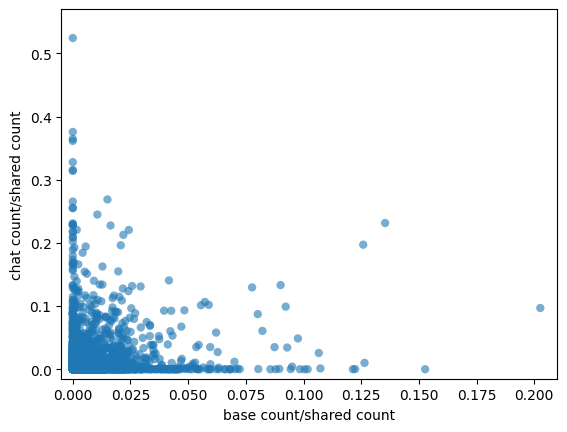

In [36]:
plt.scatter(counts[:, 1]/counts[:, 0], counts[:, 2]/counts[:, 0], alpha=.6, edgecolor='none')
plt.xlim(-.005, .21)
plt.ylim(-.015, .57)
plt.xlabel('base count/shared count')
plt.ylabel('chat count/shared count')
plt.savefig('latent_counts.png', dpi=300)

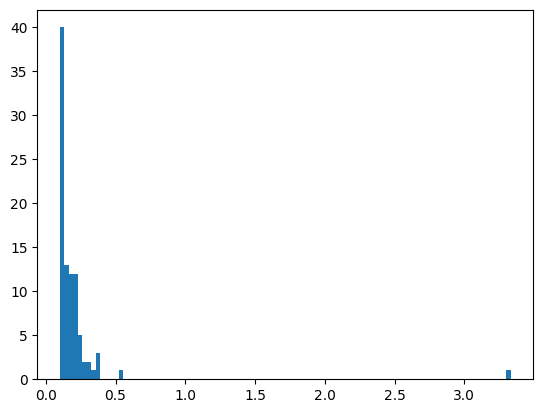

In [15]:
import matplotlib.pyplot as plt
plt.hist(counts[counts[:, 2]/counts[:, 0] > 0.1, 2]/counts[counts[:, 2]/counts[:, 0] > 0.1, 0], bins=100);

In [50]:
ids = np.argwhere(vs[:, 2]/vs[:, 0] > .2).flatten()

In [51]:
ids

array([  158,   921,  1057,  2116,  2462,  2463,  3217,  4009,  5832,
        6310,  6348,  6518,  7597,  7748,  7962,  8397,  8498,  8630,
        8735,  8752,  9291,  9418,  9627, 10615, 11569, 14643, 14738,
       15150, 15920, 16118, 16274])

In [49]:
vs[2797]

array([96,  0, 15])

In [ ]:
# understand the base exclusive features

In [47]:
np.argwhere((vs[:, 2] > 10) & (vs[:, 0] < 100))

array([[1057],
       [2797],
       [3217]])

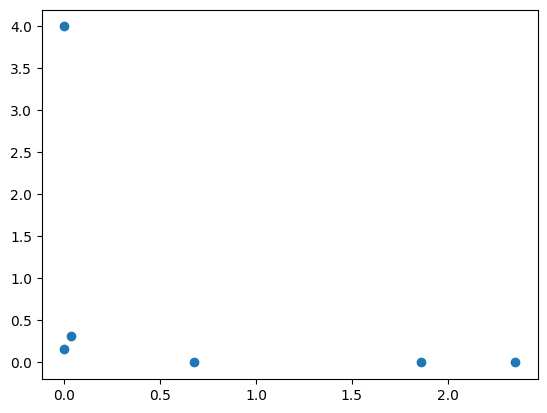

In [37]:
import matplotlib.pyplot as plt
vs = np.array(list(latent_dict.values()))
vs_filtered = vs[(vs[:, 0] < 100) & ((vs[:, 1] > 10) | (vs[:, 2] > 10))]
plt.scatter(vs_filtered[:, 1]/vs_filtered[:, 0], vs_filtered[:, 2]/vs_filtered[:, 0])

In [31]:
vss = list([[int(a) for a in v.cpu().numpy()] for v in vs])

In [49]:
sorted([(vss[ids[i]], ids[i]) for i in range(len(ids))], key=lambda x: x[0][2])

[([3, 0, 8], 1057),
 ([46, 0, 15], 3217),
 ([114, 16, 24], 7597),
 ([484, 0, 100], 4009),
 ([372, 0, 125], 2462),
 ([546, 0, 137], 2463),
 ([707, 13, 177], 921),
 ([859, 0, 179], 8735),
 ([849, 0, 180], 15150),
 ([769, 17, 181], 158),
 ([840, 23, 182], 8397),
 ([883, 0, 189], 8630),
 ([886, 16, 205], 10615),
 ([659, 0, 253], 2116),
 ([1445, 0, 295], 16118),
 ([1259, 0, 304], 9418),
 ([974, 0, 313], 14738),
 ([1358, 13, 321], 14643),
 ([1626, 9, 326], 6518),
 ([950, 0, 327], 5832),
 ([1150, 0, 337], 9291),
 ([1582, 0, 346], 6310),
 ([1324, 0, 378], 6348),
 ([2048, 0, 514], 15920),
 ([2504, 0, 549], 7748),
 ([2863, 0, 580], 7962),
 ([1136, 0, 585], 8498),
 ([2614, 0, 640], 16274),
 ([2998, 0, 1054], 8752),
 ([7119, 1, 1479], 11569),
 ([8332, 0, 1802], 9627)]

In [ ]:
921, 1057, 3217, 7597

In [37]:
ids = [  158,   921,  1057,  2116,  2462,  2463,  3217,  4009,  5832, 6310,  6348,  6518,  7597,  7748,  7962,  8397,  8498,  8630, 8735,  8752,  9291,  9418,  9627, 10615, 11569, 14643, 14738, 15150, 15920, 16118, 16274]

In [6]:
ids

[147,
 545,
 1383,
 2026,
 2116,
 3982,
 5044,
 5051,
 5832,
 6310,
 6348,
 6518,
 6918,
 7748,
 7962,
 7980,
 8450,
 8498,
 8752,
 9291,
 9418,
 9958,
 9978,
 10235,
 10615,
 11379,
 11496,
 12129,
 12838,
 13541,
 13708,
 14643,
 14705,
 14738,
 14845,
 15920,
 16118,
 16274]

In [5]:
ids = []
for i in range(2**14):
    if vs[i][0] < 5000 and (vs[i][2]>200):# or vss[i][2] > 200):
        print(i)#print(f"{i}: {vss[i]}")
        ids.append(i)

147
545
1383
2026
2116
3982
5044
5051
5832
6310
6348
6518
6918
7748
7962
7980
8450
8498
8752
9291
9418
9958
9978
10235
10615
11379
11496
12129
12838
13541
13708
14643
14705
14738
14845
15920
16118
16274


In [15]:
ids = []
for i in range(2**14):
    if latent_dict[i][0] < 4000 and (latent_dict[i][1]>200 or latent_dict[i][2] > 90):
    #if latent_dict[i][0] < 10 and (latent_dict[i][1] > 10 or latent_dict[i][2] > 10):
        print(f"{i}: {latent_dict[i]}")
        ids.append(i)

17: [2685, 168, 1]
39: [2475, 0, 978]
129: [1878, 16, 111]
147: [2680, 0, 321]
158: [756, 17, 177]
163: [488, 0, 978]
255: [1373, 0, 982]
263: [1011, 978, 1]
282: [2196, 0, 978]
310: [1334, 996, 7]
380: [1582, 98, 31]
381: [407, 0, 983]
410: [576, 1002, 0]
436: [865, 0, 985]
471: [1677, 992, 1]
507: [1674, 95, 188]
526: [581, 0, 979]
527: [2538, 123, 0]
545: [3974, 1, 332]
637: [1998, 0, 986]
735: [99, 978, 0]
800: [627, 978, 979]
894: [2067, 19, 129]
921: [698, 13, 172]
963: [1550, 190, 20]
979: [363, 1, 979]
994: [3172, 386, 0]
996: [771, 0, 978]
1224: [474, 2, 94]
1383: [1764, 47, 237]
1389: [1917, 2, 142]
1434: [1470, 993, 30]
1539: [1118, 36, 95]
1543: [1714, 0, 978]
1674: [1558, 995, 15]
1887: [1247, 39, 174]
1971: [366, 0, 982]
1978: [575, 0, 978]
2026: [2435, 0, 258]
2031: [3415, 126, 97]
2065: [1763, 0, 979]
2070: [221, 0, 978]
2116: [656, 0, 247]
2124: [878, 978, 0]
2126: [473, 0, 982]
2325: [1696, 2, 93]
2373: [719, 978, 0]
2384: [3693, 239, 0]
2462: [373, 0, 125]
2463: [539

In [18]:
dec = cross_coder.W_dec
dec_base = dec[:, 0]
dec_chat = dec[:, 1]
sims = (dec_base/dec_base.norm(dim=-1, keepdim=True)) @ (dec_chat.T / dec_chat.norm(dim=-1, keepdim=True).T)
norms = cross_coder.W_dec.norm(dim=-1)
relative_norms = norms[:, 1] / norms.sum(dim=-1)

In [20]:
sims[7079, 7079]

tensor(0.8647, device='cuda:0')

In [23]:
len(ids)

35

In [ ]:
sims[i, i] - torch.topk(sims[:, i], k=2).values[1]

tensor(0.4729, device='cuda:0')

In [30]:

diffs = []
for i in ids:
    diag = sims[i, i]
    top = torch.max(sims[:, i])
    if diag == top:
        diffs.append(diag - torch.topk(sims[:, i], k=2).values[1])
    else:
        diffs.append(diag - top)
torch.mean(torch.stack(diffs))

tensor(0.3255, device='cuda:0')

In [36]:
ids[-6]

13708

In [35]:
torch.topk(sims[:, ids[-6]], k=10)

torch.return_types.topk(
values=tensor([0.3994, 0.3779, 0.3708, 0.3651, 0.3608, 0.3538, 0.3524, 0.3461, 0.3402,
        0.3397], device='cuda:0'),
indices=tensor([14310,  9099, 10940,  9402,  4031,  6671,  2977, 15072, 14767, 11596],
       device='cuda:0'))

(array([1., 0., 3., 3., 2., 2., 5., 7., 3., 3.]),
 array([-0.09161341, -0.02431123,  0.04299095,  0.11029314,  0.17759532,
         0.24489748,  0.31219968,  0.37950188,  0.44680405,  0.51410621,
         0.58140838]),
 <BarContainer object of 10 artists>)

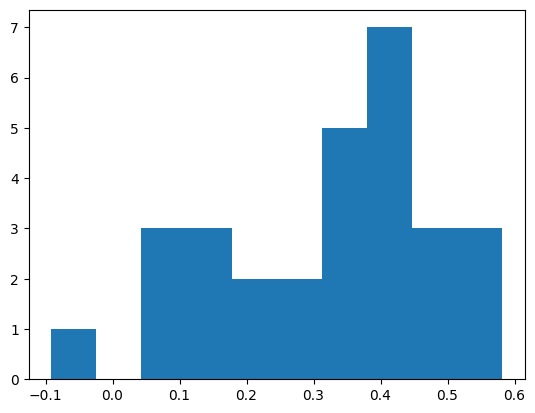

In [31]:
import matplotlib.pyplot as plt
plt.hist(torch.stack(diffs).cpu().numpy())

In [22]:
torch.mean(torch.stack([sims[i, i] - torch.topk(sims[:, i], k=2).values[1] for i in ids]))

tensor(0.3113, device='cuda:0')

In [26]:
ids = []
for i in range(2**14):
    if latent_dict[i][0] < 600 and (latent_dict[i][1]>35 or latent_dict[i][2] > 35) and latent_dict[i][1] < latent_dict[i][2]:
    #if latent_dict[i][0] < 10 and (latent_dict[i][1] > 10 or latent_dict[i][2] > 10):
        print(f"{i}: {latent_dict[i]}")
        ids.append(i)

147: [485, 0, 67]
507: [340, 20, 38]
1383: [305, 13, 53]
2026: [538, 0, 59]
3738: [198, 8, 41]
3982: [578, 0, 84]
5044: [336, 6, 72]
6310: [274, 0, 77]
6518: [284, 3, 51]
6918: [332, 0, 37]
7748: [554, 0, 117]
8081: [447, 23, 36]
8389: [231, 0, 37]
8498: [182, 0, 71]
8752: [420, 0, 174]
9291: [203, 0, 44]
9418: [205, 0, 60]
9830: [468, 4, 57]
10235: [597, 0, 51]
10335: [340, 2, 39]
11379: [493, 0, 62]
11496: [542, 17, 80]
13541: [552, 0, 56]
13708: [394, 0, 45]
14643: [141, 2, 47]
14738: [82, 0, 36]
14845: [435, 0, 79]
15920: [196, 0, 49]
16274: [578, 0, 172]


In [7]:
ids = []
for i in range(2**14):
    if 100 > latent_dict[i][0] and latent_dict[i][2] > 20:
    #if latent_dict[i][0] < 10 and (latent_dict[i][1] > 10 or latent_dict[i][2] > 10):
        print(f"{i}: {latent_dict[i]}")
        ids.append(i)

20: [94, 6, 32]
27: [26, 4, 27]
94: [86, 6, 53]
130: [45, 12, 24]
252: [52, 6, 22]
303: [43, 3, 35]
340: [64, 0, 46]
355: [93, 17, 26]
484: [73, 6, 35]
515: [73, 3, 24]
534: [56, 6, 25]
598: [77, 0, 34]
774: [44, 4, 27]
787: [92, 6, 30]
844: [77, 2, 33]
858: [77, 13, 24]
920: [58, 9, 33]
941: [95, 12, 50]
997: [71, 5, 24]
1022: [68, 3, 39]
1061: [95, 8, 44]
1076: [43, 1, 28]
1077: [78, 12, 22]
1083: [80, 10, 24]
1188: [47, 3, 35]
1223: [26, 3, 21]
1277: [93, 4, 77]
1371: [61, 6, 24]
1425: [79, 6, 52]
1446: [70, 6, 46]
1541: [83, 26, 42]
1591: [94, 23, 64]
1761: [43, 0, 32]
1764: [87, 2, 28]
1823: [94, 0, 25]
1904: [41, 8, 26]
1969: [34, 2, 27]
2067: [93, 0, 25]
2085: [82, 0, 25]
2088: [96, 5, 52]
2118: [79, 6, 21]
2122: [83, 3, 44]
2291: [61, 1, 28]
2330: [57, 6, 30]
2435: [69, 14, 85]
2462: [46, 0, 55]
2467: [77, 12, 24]
2582: [49, 0, 25]
2707: [96, 3, 29]
2714: [51, 9, 45]
2822: [97, 7, 37]
2880: [93, 9, 56]
2919: [55, 0, 46]
2937: [91, 6, 60]
2969: [68, 4, 23]
2992: [45, 5, 61]
3108

In [32]:
ids = []
for i in range(2**14):
    if latent_dict[i][0] < 750 and (latent_dict[i][1]>160 or latent_dict[i][2] > 270):
    #if latent_dict[i][0] < 10 and (latent_dict[i][1] > 10 or latent_dict[i][2] > 10):
        print(f"{i}: {latent_dict[i]}")
        ids.append(i)

64: [309, 70, 271]
898: [661, 44, 277]
1570: [680, 8, 300]
1766: [645, 27, 471]
3342: [650, 25, 305]
3891: [430, 25, 312]
5239: [638, 59, 357]
5834: [399, 58, 356]
6703: [571, 126, 296]
6732: [81, 177, 34]
6918: [658, 96, 290]
7055: [570, 167, 191]
7748: [423, 44, 322]
8013: [382, 73, 322]
8752: [406, 98, 381]
9297: [230, 464, 160]
10084: [275, 44, 277]
10312: [524, 122, 413]
10449: [717, 157, 289]
11734: [721, 168, 181]
11997: [373, 59, 272]
14845: [495, 9, 323]
15571: [208, 232, 19]
15940: [718, 56, 316]


In [16]:
ids = []
for i in range(2**14):
    if (50 < latent_dict[i][1] or 50 < latent_dict[i][2]) and 600 > latent_dict[i][0]:
    #if latent_dict[i][0] < 10 and (latent_dict[i][1] > 10 or latent_dict[i][2] > 10):
        print(f"{i}: {latent_dict[i]}")
        ids.append(i)


13: [510, 15, 69]
145: [277, 4, 58]
158: [159, 4, 55]
731: [393, 33, 69]
1383: [421, 35, 55]
2112: [179, 2, 57]
3471: [357, 3, 59]
3721: [431, 5, 51]
3738: [148, 6, 55]
3745: [582, 15, 55]
3755: [262, 2, 65]
3819: [243, 5, 51]
4832: [513, 4, 53]
5428: [554, 16, 102]
5655: [214, 0, 82]
5667: [383, 18, 64]
6564: [456, 12, 55]
7113: [566, 6, 66]
7346: [245, 12, 59]
7554: [420, 1, 58]
7583: [303, 12, 62]
7616: [296, 21, 104]
7748: [528, 2, 159]
8013: [307, 14, 78]
8498: [182, 8, 58]
8505: [286, 10, 100]
8570: [282, 12, 85]
8648: [305, 21, 51]
8716: [93, 55, 1]
8752: [424, 8, 225]
8784: [585, 8, 69]
9297: [261, 121, 20]
9830: [423, 7, 97]
10281: [391, 5, 57]
10335: [596, 25, 60]
10633: [497, 5, 109]
10636: [441, 8, 77]
11448: [336, 2, 58]
11463: [370, 4, 72]
11496: [414, 17, 88]
11733: [148, 1, 51]
12330: [189, 11, 51]
12451: [505, 5, 56]
12953: [151, 1, 62]
13241: [427, 0, 55]
13856: [581, 11, 90]
14382: [142, 13, 51]
14599: [532, 7, 121]
14845: [446, 2, 83]


In [17]:
ids = []
for i in range(2**14):
    if (35 < latent_dict[i][1] or 35 < latent_dict[i][2]) and 600 > latent_dict[i][0]:
    #if latent_dict[i][0] < 10 and (latent_dict[i][1] > 10 or latent_dict[i][2] > 10):
        print(f"{i}: {latent_dict[i]}")
        ids.append(i)


147: [485, 0, 67]
507: [340, 20, 38]
963: [306, 44, 11]
994: [556, 47, 0]
1383: [305, 13, 53]
2026: [538, 0, 59]
3738: [198, 8, 41]
3982: [578, 0, 84]
5044: [336, 6, 72]
6310: [274, 0, 77]
6518: [284, 3, 51]
6918: [332, 0, 37]
6983: [392, 39, 0]
7748: [554, 0, 117]
8081: [447, 23, 36]
8389: [231, 0, 37]
8498: [182, 0, 71]
8752: [420, 0, 174]
9134: [358, 37, 1]
9291: [203, 0, 44]
9418: [205, 0, 60]
9634: [552, 51, 0]
9830: [468, 4, 57]
10235: [597, 0, 51]
10335: [340, 2, 39]
11379: [493, 0, 62]
11496: [542, 17, 80]
13541: [552, 0, 56]
13708: [394, 0, 45]
14643: [141, 2, 47]
14738: [82, 0, 36]
14845: [435, 0, 79]
15920: [196, 0, 49]
16274: [578, 0, 172]
16379: [569, 37, 0]


In [14]:
ids = []
for i in range(2**14):
    if (35 < latent_dict[i][1] or 35 < latent_dict[i][2]) and 600 > latent_dict[i][0]:
    #if latent_dict[i][0] < 10 and (latent_dict[i][1] > 10 or latent_dict[i][2] > 10):
        print(f"{i}: {latent_dict[i]}")
        ids.append(i)


147: [485, 0, 67]
507: [340, 20, 38]
963: [306, 44, 11]
994: [556, 47, 0]
1383: [305, 13, 53]
2026: [538, 0, 59]
3738: [198, 8, 41]
3982: [578, 0, 84]
5044: [336, 6, 72]
6310: [274, 0, 77]
6518: [284, 3, 51]
6918: [332, 0, 37]
6983: [392, 39, 0]
7748: [554, 0, 117]
8081: [447, 23, 36]
8389: [231, 0, 37]
8498: [182, 0, 71]
8752: [421, 0, 174]
9134: [358, 37, 1]
9291: [208, 0, 44]
9418: [205, 0, 60]
9634: [552, 51, 0]
9830: [468, 4, 57]
10235: [597, 0, 51]
10335: [340, 2, 39]
11379: [493, 0, 62]
11496: [542, 17, 80]
13541: [552, 0, 56]
13708: [396, 0, 45]
14643: [141, 2, 47]
14738: [82, 0, 36]
14845: [436, 0, 79]
15920: [196, 0, 49]
16274: [578, 0, 172]
16379: [570, 37, 0]


In [ ]:
ids = []
for i in range(2**14):
    if latent_dict[i][0] < latent_dict[i][1] or latent_dict[i][0] < latent_dict[i][2]:
    #if latent_dict[i][0] < 10 and (latent_dict[i][1] > 10 or latent_dict[i][2] > 10):
        print(f"{i}: {latent_dict[i]}")
        ids.append(i)


5187: [2, 5, 0]


In [13]:
all_latents = []
for entry in range(num_entries):
    for tok in range(seq_len):
        latents_1 = torch.argwhere(latents[entry, tok, 1] > 0).reshape(-1).cpu().numpy()
        latents_2 = torch.argwhere(latents[entry, tok, 2] > 0).reshape(-1).cpu().numpy()
        print(f"{entry:<2} {tok:<2} {len(torch.argwhere(latents[entry, tok, 1] > 0)):<3} {len(torch.argwhere(latents[entry, tok, 2] > 0)):<4} {tokenizer.decode(tokens[entry][tok]):<10} {latents_1[:10]} {latents_2[:10]}")
        if len(latents_1) < 15: all_latents.append(latents_1)
        if len(latents_2) < 15: all_latents.append(latents_2)
    print()

all_latents = np.concatenate(all_latents)

0  0  60  100  <bos>      [ 263  310  410  471  735  800 1434 1674 2124 2373] [ 39 163 255 282 381 436 526 637 800 979]
0  1  0   0    Please     [] []
0  2  1   1     answer    [7462] [6726]
0  3  1   1     to        [7462] [6726]
0  4  1   2     the       [1260] [ 6726 11186]
0  5  0   1     following [] [6726]
0  6  0   0     five      [] []
0  7  0   0     prompts   [] []
0  8  1   3    .          [11946] [ 5779  6726 14384]
0  9  0   4    
          [] [ 6726  8630  8651 14384]
0  10 1   0    1          [14242] []
0  11 0   0    )          [] []
0  12 1   0               [11651] []
0  13 0   1    Can        [] [4853]
0  14 0   2     you       [] [ 3962 12317]
0  15 0   2     recommend [] [9812 9883]
0  16 0   0     a         [] []
0  17 0   0     chocolate [] []
0  18 0   0     cake      [] []
0  19 0   0     recipe    [] []
0  20 0   0     for       [] []
0  21 0   1     two       [] [6625]
0  22 4   4    ?          [ 1269  8862 13320 13508] [ 1807  8488  9739 13873]
0  23 0   4 

In [ ]:
len(set(all_latents))

397

In [15]:
ids = [int(latent) for latent in set(all_latents)]

In [ ]:
ids = torch.cat([torch.argwhere(latents[i, 1] > 0) for i in range(5)])
ids = torch.cat([ids] + [torch.argwhere(latents[i, 2] > 0) for i in range(5)])
ids.squeeze()

tensor([12506,  8732,  7586, 12110, 13844, 14457,   887,  7450, 10992, 12838],
       device='cuda:0')

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it")
for i in range(10): print(f"{i}: {tokenizer.decode(tokens[i][-30:])}")

0: , I believe the new bug listing look came out of your discussions with Huw, right?
<nigelb> :)
<jml> m
1: ErrorMsg_000000000000219768_EA"></span></div><div class="
2: "EventPattern": {
                    "source": [
                        "aws.health"
                    ],
                    "detail-type": [

3:  hakama, a type of pants worn during the Edo period. He is also known for his distinctive eye patch, which covers his right eye.

4:  of 28 cents versus 1 cent a year ago.

TowerJazz lost money for years following heavy investments in a second chip plant in Israel
5: array}{c}
(B(s))_{ij}=\dfrac{1}{\vert Y^\ast \vert}\displaystyle \int_{Y^{\


IndexError: index 6 is out of bounds for dimension 0 with size 6

In [21]:
for a,b, c in zip(latents[i, 0, nonzero_locs_2], latents[i, 1, nonzero_locs_2], latents[i, 2, nonzero_locs_2]): print(a,b,c)

tensor([19.6273], device='cuda:0') tensor([0.], device='cuda:0') tensor([17.8575], device='cuda:0')
tensor([31.7542], device='cuda:0') tensor([0.], device='cuda:0') tensor([0.5249], device='cuda:0')
tensor([8.7669], device='cuda:0') tensor([0.], device='cuda:0') tensor([1.2828], device='cuda:0')
tensor([11.8784], device='cuda:0') tensor([0.], device='cuda:0') tensor([0.6612], device='cuda:0')
tensor([126.5259], device='cuda:0') tensor([0.], device='cuda:0') tensor([1.3815], device='cuda:0')
tensor([0.], device='cuda:0') tensor([0.], device='cuda:0') tensor([2.4605], device='cuda:0')
tensor([9.7816], device='cuda:0') tensor([0.], device='cuda:0') tensor([17.8259], device='cuda:0')
tensor([0.], device='cuda:0') tensor([0.], device='cuda:0') tensor([2.2632], device='cuda:0')
tensor([0.], device='cuda:0') tensor([0.], device='cuda:0') tensor([0.0850], device='cuda:0')


In [14]:
i=2
nonzero_locs_0 = torch.argwhere(latents[i, 0] > 0)
nonzero_locs_1 = torch.argwhere(latents[i, 1] > 0)
nonzero_locs_2 = torch.argwhere(latents[i, 2] > 0)

avg_activation_0 = latents[i, 0, nonzero_locs_1].mean()
avg_activation_1 = latents[i, 1, nonzero_locs_1].mean()
avg_activation_2 = latents[i, 2, nonzero_locs_2].mean()

print(f"Average activation of latents[0, 0] at nonzero locations: {avg_activation_0.item()}")
print(f"Average activation of latents[0, 1] at nonzero locations: {avg_activation_1.item()}")
print(f"Average activation of latents[0, 2] at nonzero locations: {avg_activation_2.item()}")

Average activation of latents[0, 0] at nonzero locations: nan
Average activation of latents[0, 1] at nonzero locations: nan
Average activation of latents[0, 2] at nonzero locations: 4.926930904388428


In [ ]:

# Visualize the distribution of latent norms
import matplotlib.pyplot as plt

plt.hist(latent_norms.detach().cpu().numpy(), bins=200)
plt.title("Latent Norms Distribution")
plt.xlabel("Latent Norms")
plt.ylabel("Number of Latents")
plt.xticks([0, 0.25, 0.5, 0.75, 1.0], ['0', '0.25', '0.5', '0.75', '1.0'])
plt.show()


In [13]:
!pip show nbformat

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Name: nbformat
Version: 5.10.4
Summary: The Jupyter Notebook format
Home-page: https://jupyter.org
Author: 
Author-email: Jupyter Development Team <jupyter@googlegroups.com>
License: BSD 3-Clause License

- Copyright (c) 2001-2015, IPython Development Team
- Copyright (c) 2015-, Jupyter Development Team

All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior writte